# Tutorial 0: Basic examples

In [1]:
import warnings
import sys
warnings.filterwarnings('ignore')

from sklearn.datasets import load_diabetes
from synthcity.plugins import Plugins
import synthcity.logger as log

log.add(sink=sys.stderr, level="INFO")

X, y = load_diabetes(return_X_y=True, as_frame=True)
X["target"] = y

X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


## List the available generative models

In [2]:
from synthcity.plugins import Plugins

Plugins().list()

['marginal_distributions',
 'gaussian_copula',
 'ctgan',
 'dummy_sampler',
 'uniform_sampler',
 'tvae',
 'privbayes',
 'adsgan',
 'copulagan',
 'pategan']

## Load and train a generative model

In [3]:
from synthcity.plugins import Plugins

syn_model = Plugins().get("marginal_distributions")

syn_model.fit(X)

## Generate new data using the model

In [4]:
syn_model.generate(count = 10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.017933,-0.044642,0.006171,-0.031428,0.123543,0.040020,-0.093352,0.110671,-0.004165,-0.004758,201.037415
1,0.069457,-0.044642,0.092033,0.003711,0.057900,0.011496,-0.054827,-0.000539,-0.116662,-0.039370,271.590583
2,-0.089330,-0.044642,0.099834,-0.075232,-0.055448,0.114418,0.169313,0.066711,-0.084699,-0.062403,66.440005
3,0.087065,-0.044642,0.005169,-0.062250,-0.027253,-0.046673,0.040117,0.083389,-0.079541,0.022811,276.152723
4,0.053960,0.050680,0.150064,0.118076,0.075851,0.053367,0.083588,-0.032787,0.029415,0.008078,137.440560
5,-0.089247,-0.044642,-0.022531,-0.091760,-0.059465,-0.033640,-0.030185,0.161971,-0.036500,0.048987,152.878816
6,0.027255,-0.044642,-0.070936,0.020958,-0.098499,-0.055755,0.157634,0.149831,0.028359,0.108033,179.383302
7,0.018842,-0.044642,-0.042002,0.035176,-0.034314,0.028096,0.007798,0.025361,-0.109608,-0.010869,64.901763
8,0.078991,-0.044642,0.097912,-0.073530,-0.093373,-0.066487,0.038753,0.143850,-0.010700,-0.035409,44.162364
9,-0.019618,-0.044642,0.070838,-0.006987,0.049998,0.100770,-0.049598,-0.009088,-0.031018,0.029251,56.301004


## Generate new data under some constraints

In [5]:
# Constraint: target <= 100
from synthcity.plugins.core.constraints import Constraints

constraints = Constraints(rules = [("target", "<=", 100)])

generated = syn_model.generate(count = 10, constraints = constraints)

assert (generated["target"] <= 100).any()

generated

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.233410e+08
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.259525e+09
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.164073e+09
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.819311e+08
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.623212e+09
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.135879e+08
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.354254e+08
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.859734e+08
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.460145e+09
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.623516e+09


In [6]:
# Constraint: target > 150

from synthcity.plugins.core.constraints import Constraints

constraints = Constraints(rules = [("target", ">", 150)])

generated = syn_model.generate(count = 10, constraints = constraints)

assert (generated["target"] > 150).any()

generated

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.434256e+07
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.171992e+08
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.834961e+09
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.369820e+09
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.059414e+08
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.943136e+09
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.970420e+08
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.405484e+08
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.535708e+08
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.139320e+09


## Plot real-synthetic distributions

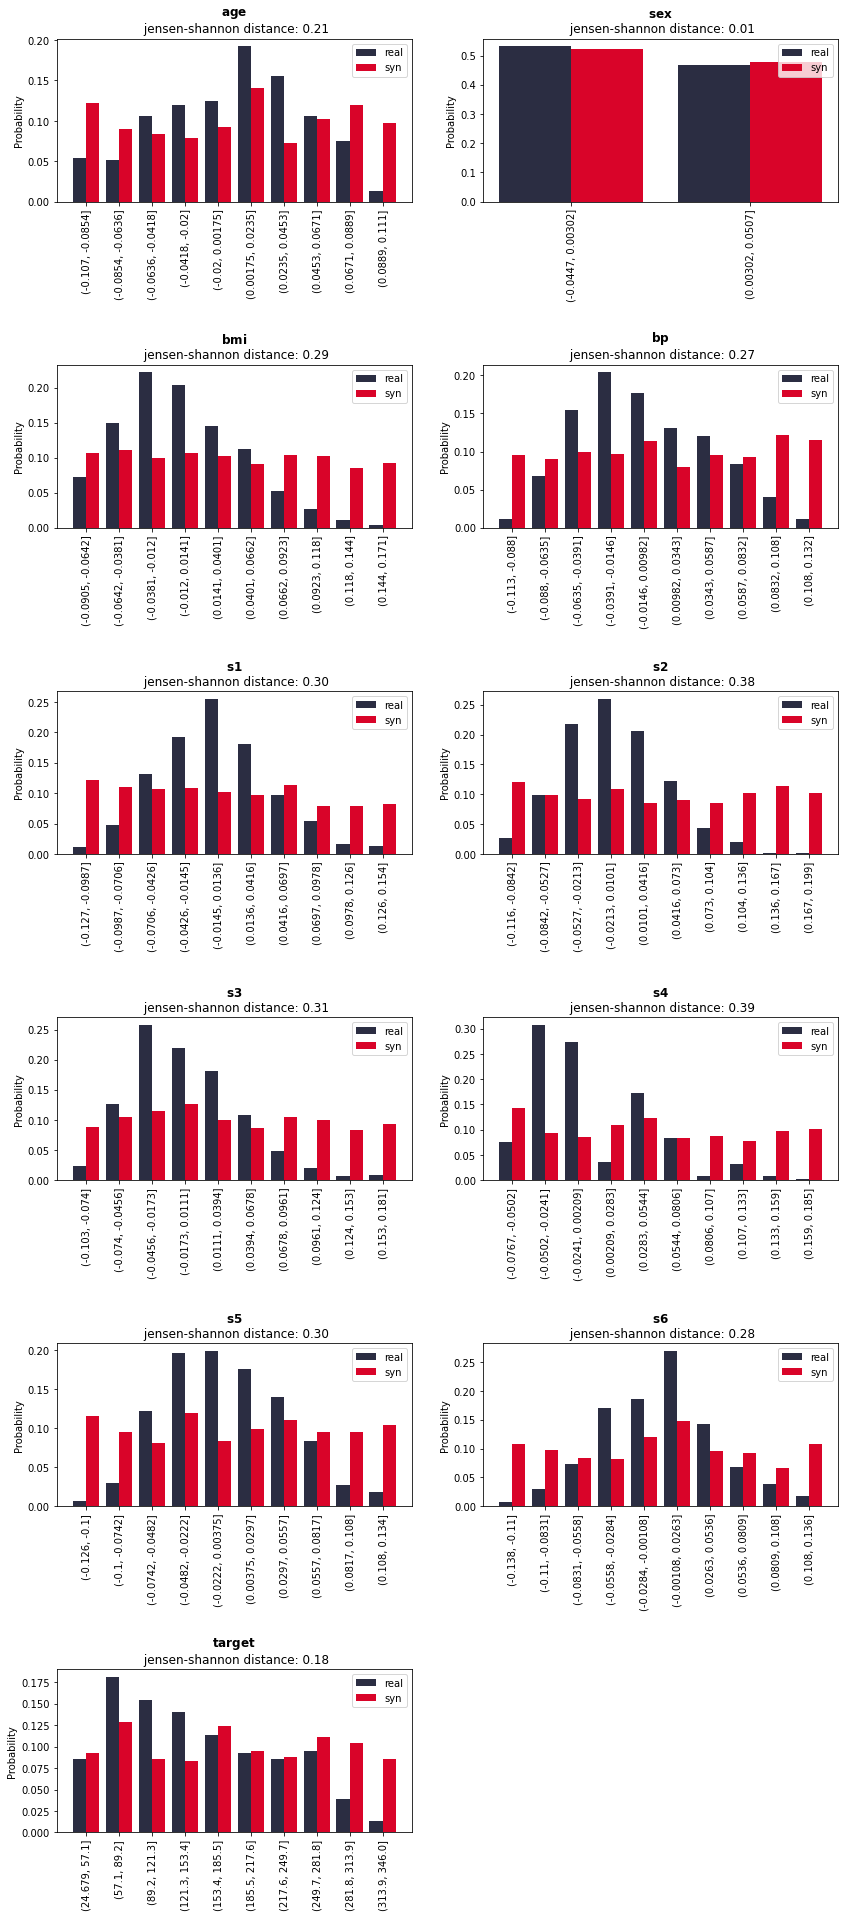

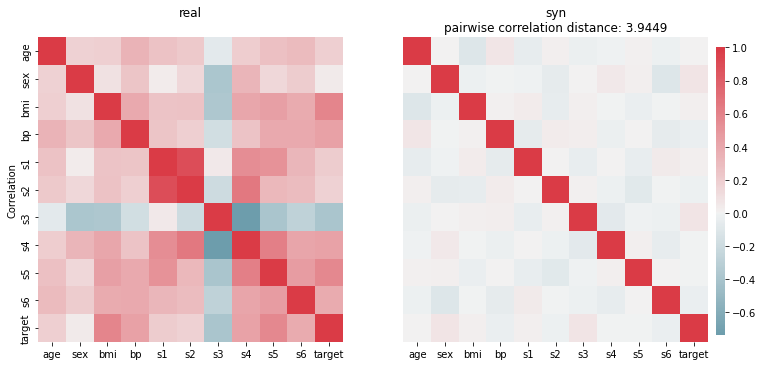

In [7]:
import matplotlib.pyplot as plt

syn_model.plot(plt, X)

plt.show()

## Benchmark the quality of plugins

In [8]:
from synthcity.benchmark import Benchmarks
constraints = Constraints(rules = [("target", "ge", 150)])

score = Benchmarks.evaluate(
    ["marginal_distributions", "dummy_sampler"],
    X,
    sensitive_columns = ["sex"],
    synthetic_size = 1000,
    synthetic_constraints = constraints,
    repeats = 5,
)


[2022-03-26T22:29:35.033401+0000][1131190][INFO] Benchmarking plugin : marginal_distributions
[2022-03-26T22:29:35.035337+0000][1131190][INFO]  Experiment repeat: 0
[2022-03-26T22:30:04.502650+0000][1131190][INFO]  Experiment repeat: 1
[2022-03-26T22:30:34.617338+0000][1131190][INFO]  Experiment repeat: 2
[2022-03-26T22:31:05.314737+0000][1131190][INFO]  Experiment repeat: 3
[2022-03-26T22:31:37.525631+0000][1131190][INFO]  Experiment repeat: 4
[2022-03-26T22:32:05.196201+0000][1131190][INFO] Benchmarking plugin : dummy_sampler
[2022-03-26T22:32:05.196877+0000][1131190][INFO]  Experiment repeat: 0
[2022-03-26T22:33:23.989871+0000][1131190][INFO]  Experiment repeat: 1
[2022-03-26T22:34:39.796355+0000][1131190][INFO]  Experiment repeat: 2
[2022-03-26T22:35:50.116669+0000][1131190][INFO]  Experiment repeat: 3
[2022-03-26T22:36:58.810533+0000][1131190][INFO]  Experiment repeat: 4


In [9]:
Benchmarks.print(score)


Comparatives


,marginal_distributions,dummy_sampler
sanity.data_mismatch_score,0.0,0.0
sanity.common_rows_proportion,0.0,0.456109
sanity.avg_distance_nearest_neighbor,0.603946,0.253658
sanity.inlier_probability,0.052036,0.565611
sanity.outlier_probability,0.266968,0.047511
statistical.inverse_kl_divergence,0.055061,0.788098
statistical.kolmogorov_smirnov_test,0.409297,0.813901
statistical.chi_squared_test,0.0,0.361728
statistical.maximum_mean_discrepancy,0.009774,0.010825
statistical.inverse_cdf_distance,0.330254,2.293051



Plugin : marginal_distributions


,min,max,mean,stddev,median,iqr,rounds,errors,durations
sanity.data_mismatch_score,0.0,0.0,0.0,0.0,0.0,0.0,5,0,0.0
sanity.common_rows_proportion,0.0,0.0,0.0,0.0,0.0,0.0,5,0,0.01
sanity.avg_distance_nearest_neighbor,0.603946,0.603946,0.603946,0.0,0.603946,0.0,5,0,0.01
sanity.inlier_probability,0.052036,0.052036,0.052036,0.0,0.052036,0.0,5,0,0.01
sanity.outlier_probability,0.266968,0.266968,0.266968,0.0,0.266968,0.0,5,0,0.01
statistical.inverse_kl_divergence,0.055061,0.055061,0.055061,0.0,0.055061,0.0,5,0,0.02
statistical.kolmogorov_smirnov_test,0.409297,0.409297,0.409297,0.0,0.409297,0.0,5,0,0.23
statistical.chi_squared_test,0.0,0.0,0.0,0.0,0.0,0.0,5,0,0.02
statistical.maximum_mean_discrepancy,0.009774,0.009774,0.009774,0.0,0.009774,0.0,5,0,0.08
statistical.inverse_cdf_distance,0.327099,0.332597,0.330254,0.002257,0.33152,0.004082,5,0,0.92




Plugin : dummy_sampler


,min,max,mean,stddev,median,iqr,rounds,errors,durations
sanity.data_mismatch_score,0.0,0.0,0.0,0.0,0.0,0.0,5,0,0.0
sanity.common_rows_proportion,0.452489,0.459276,0.456109,0.003069,0.457014,0.006787,5,0,0.01
sanity.avg_distance_nearest_neighbor,0.253651,0.253675,0.253658,0.000009,0.253655,0.000008,5,0,0.01
sanity.inlier_probability,0.565611,0.565611,0.565611,0.0,0.565611,0.0,5,0,0.01
sanity.outlier_probability,0.047511,0.047511,0.047511,0.0,0.047511,0.0,5,0,0.01
statistical.inverse_kl_divergence,0.783679,0.792004,0.788098,0.003108,0.788613,0.005146,5,0,0.01
statistical.kolmogorov_smirnov_test,0.806666,0.819627,0.813901,0.0044,0.815631,0.004156,5,0,0.19
statistical.chi_squared_test,0.359478,0.363006,0.361728,0.001279,0.362231,0.001494,5,0,0.01
statistical.maximum_mean_discrepancy,0.01054,0.011186,0.010825,0.000224,0.010836,0.000266,5,0,0.08
statistical.inverse_cdf_distance,2.265064,2.306534,2.293051,0.014695,2.296132,0.00894,5,0,6.2


In [34]:
import pandas as pd
import numpy as np

means = []
for plugin in score:
    data = score[plugin]["mean"]
    good_scores =  score[plugin]["ok_score"].to_dict()
    bad_scores =  score[plugin]["bad_score"].to_dict()
    means.append(data)
    
out = pd.concat(means, axis = 1)
out.set_axis(score.keys(), axis=1, inplace=True)

bad_highlight = 'background-color: lightcoral;'
ok_highlight = 'background-color: green;'
default = ''

def highlights(row):    
    metric = row.name
    if good_scores[metric] < bad_scores[metric]:
        best_val = np.min(row.values)
        worst_val = np.max(row)
    else:
        best_val = np.max(row.values)
        worst_val = np.min(row)
        
    styles = []
    for val in row.values:
        if val == best_val:
            styles.append(ok_highlight)
        elif val == worst_val:
            styles.append(bad_highlight)
        else:
            styles.append(default)
            
    return styles

out.style.apply(highlights, axis=1)

,marginal_distributions,dummy_sampler
sanity.data_mismatch_score,0.000000,0.000000
sanity.common_rows_proportion,0.000000,0.456109
sanity.avg_distance_nearest_neighbor,0.603946,0.253658
sanity.inlier_probability,0.052036,0.565611
sanity.outlier_probability,0.266968,0.047511
statistical.inverse_kl_divergence,0.055061,0.788098
statistical.kolmogorov_smirnov_test,0.409297,0.813901
statistical.chi_squared_test,0.000000,0.361728
statistical.maximum_mean_discrepancy,0.009774,0.010825
statistical.inverse_cdf_distance,0.330254,2.293051


# 